## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
!nvidia-smi

Mon Nov 25 15:27:54 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import itertools

In [4]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [ ]:
train, test = keras.datasets.cifar10.load_data()

In [ ]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [ ]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [ ]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 256, 128, 64], l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
#             x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1), kernel_regularizer=l2(l2_ratio))(input_layer)
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1), 
            kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
#             x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1), kernel_regularizer=l2(l2_ratio))(x)
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1), 
            kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [ ]:

"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 100
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

In [10]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for l1r, l2r in itertools.product( L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}




Experiment with L1 = 0.010000, L2 = 0.010000


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
hidden_layer4 (Dense)        (None, 128)               32896     
_________________________________________________________________
hidden_layer5 (Dense)        (None, 64)                8256      
_________________________________________________________________
output (D

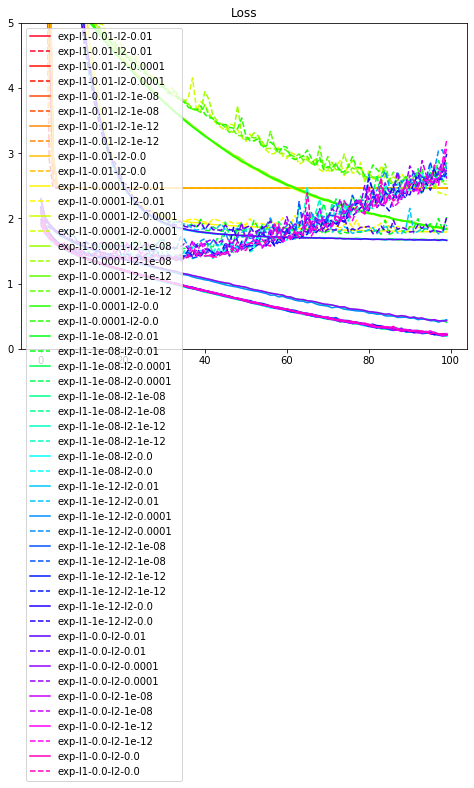

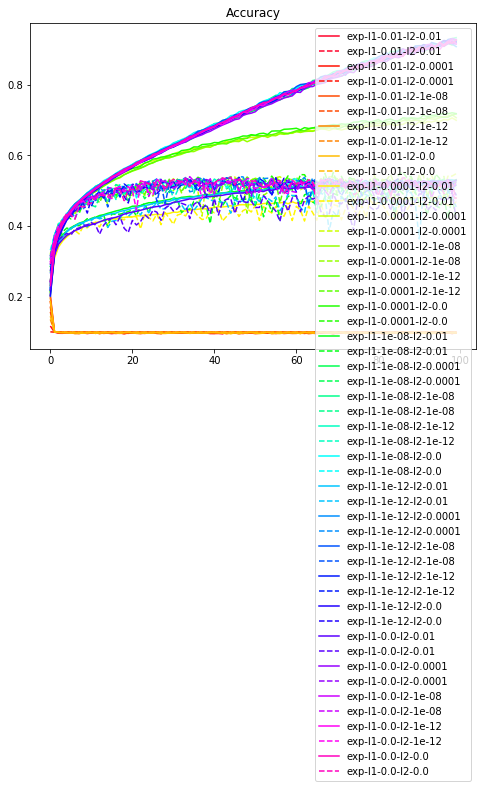

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

# color_bar = ["r", "g", "b", "y", "m", "k"]

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()